In [5]:
import os, json

import numpy as np
import keras

In [1]:
files_path = "http://files.fast.ai/models/"
class_file = "imagenet_class_index.json"

In [3]:
from keras.utils.data_utils import get_file

In [17]:
fpath = get_file(class_file, files_path + class_file, cache_subdir="models")

with open(fpath) as f:
    class_dict = json.load(f)

classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [18]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

In [22]:
from keras.models import Sequential, Model

### Required for convolutional block

In [20]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

In [21]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation="relu"))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

### Required for fully-connected block

In [23]:
from keras.layers.core import Dense, Dropout

In [24]:
def FCBlock(model):
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))

### Preprocessing data (RGB > BGR)

In [25]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3, 1, 1))

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

In [26]:
vgg_mean

array([[[ 123.68 ]],

       [[ 116.779]],

       [[ 103.939]]])

Why a 3D array?

In [27]:
from keras.layers.core import Lambda, Flatten

### VGG using Keras components

In [30]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224)))
    
    # Convolution layers are for finding patterns in images
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    # Dense (FC) layers are for combining patterns across an image
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation="softmax"))
    return model

In [31]:
model = VGG_16()

In [32]:
fpath = get_file("vgg16.h5", files_path + "vgg16.h5", cache_subdir="models")
model.load_weights(fpath)

In [33]:
batch_size = 4

In [56]:
from keras.preprocessing import image

In [37]:
import os

In [41]:
c_dir = os.getcwd()

In [47]:
data_dir = c_dir + "/../data/kg/cd-redux/sample/"

In [62]:
def get_batches(
        dirname,
        gen=image.ImageDataGenerator(),
        shuffle=True,
        batch_size=batch_size,
        class_mode="categorical"
    ):
    return gen.flow_from_directory(
        data_dir + dirname,
        target_size=(224, 224),
        class_mode=class_mode,
        shuffle=shuffle,
        batch_size=batch_size
    )

In [70]:
%matplotlib inline

from utils import plots

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


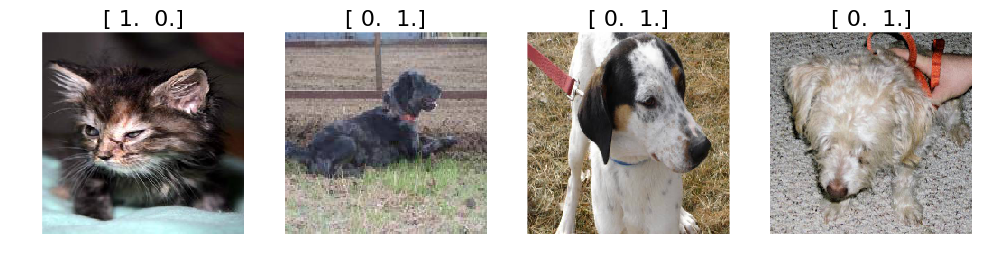

In [72]:
batches = get_batches("train")
val_batches = get_batches("valid")

imgs, labels = next(batches)
plots(imgs, titles=labels)

In [103]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)
    
    print("Shape: {}".format(preds.shape))
    print("First 5 classes: {}".format(classes[:5]))
    print("First 5 probabilities: {}\n".format(preds[0, :5]))
    
    print("Predictions prob/class:")
    for i in range(len(idxs)):
        idx = idxs[i]
        print("{:0.2f} - {}".format(preds[i, idx], classes[idx]))

In [104]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  2.7201e-08   1.0201e-06   5.4907e-08   3.2996e-07   2.5964e-08]

Predictions prob/class:
0.49 - tabby
0.22 - Scottish_deerhound
0.76 - Walker_hound
0.48 - soft-coated_wheaten_terrier
